In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

In [2]:
class Dataset:
    def __init__(self, filepath, CTX_SZ):
        self.words = [w.lower().strip() for w in open(filepath, "r", encoding="utf8").readlines() if len(w) > 1]
        self.letters = list(set(''.join(self.words)))
        self.chtoi = { ch:(i+1) for i, ch in enumerate(self.letters) }
        self.chtoi['.'] = 0
        self.itoch = { i:ch for ch, i in self.chtoi.items() }
        self.N_SYM = len(self.chtoi)
        
        self.CTX_SZ = CTX_SZ
        self.x, self.y = [], []
        for w in self.words:
            ctx = [0] * self.CTX_SZ
            for ch in w + '.':
                idx = self.chtoi[ch]
                self.x.append(ctx)
                self.y.append(idx)
                ctx = ctx[1:] + [idx]
        self.N_SAMPLES = len(self.x)
        
        tmp = list(zip(self.x, self.y))
        random.shuffle(tmp)
        self.x, self.y = zip(*tmp)
        self.x, self.y = list(self.x), list(self.y)
        
class MLP(torch.nn.Module):
    def __init__(self, N_SYM, CTX_SZ, EMB_SZ, HID_SZ):
        super().__init__()
        self.CTX_SZ = CTX_SZ
        self.EMB_SZ = EMB_SZ
        self.HID_SZ = HID_SZ
        self.C = torch.nn.Parameter(torch.randn((N_SYM, EMB_SZ)))
        self.W1 = torch.nn.Parameter(torch.empty((EMB_SZ * CTX_SZ, HID_SZ)))
        torch.nn.init.kaiming_normal_(self.W1, nonlinearity='tanh')
        self.b1 = torch.nn.Parameter(torch.randn(HID_SZ) * 0.01)
        self.W2 = torch.nn.Parameter(torch.randn((HID_SZ, N_SYM)) * 0.01)
        self.b2 = torch.nn.Parameter(torch.randn(N_SYM) * 0)

    def forward(self, x, bix = None):
        batch = (self.C[x] if bix is None else self.C[x[bix]])
        emb = (batch.view(-1, self.EMB_SZ * self.CTX_SZ))
        h = (torch.tanh(emb @ self.W1 + self.b1))
        logits = (h @ self.W2 + self.b2)
        return logits

    def scatter_plot_C(self):        
        plt.figure(figsize=(8,8))
        plt.scatter(model.C[:,0].cpu().data, model.C[:,1].cpu().data, s=200)
        for i in range(model.C.shape[0]):
            plt.text(model.C[i,0].item(), model.C[i,1].item(), d.itoch[i], ha='center', va='center', color='white')
        return plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

d = Dataset("towns.txt", CTX_SZ = 3)

splt1 = int(d.N_SAMPLES * 0.8)
splt2 = int(d.N_SAMPLES * 0.9)
x_trn, y_trn = torch.tensor(d.x[:splt1], device=device), torch.tensor(d.y[:splt1], device=device)
x_dev, y_dev = torch.tensor(d.x[splt1:splt2], device=device), torch.tensor(d.y[splt1:splt2], device=device)
x_tst, y_tst = torch.tensor(d.x[splt2:], device=device), torch.tensor(d.y[splt2:], device=device)

model = MLP(d.N_SYM, d.CTX_SZ, EMB_SZ=2, HID_SZ=100).to(device)

In [4]:
def eval_loss(x, y):
    with torch.no_grad():
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        print(loss.item())
eval_loss(x_trn, y_trn)
eval_loss(x_dev, y_dev)

3.554480791091919
3.553743600845337


In [5]:
ITS = 20000
MB_SZ = 10000 if device == 'cuda' else 128

optimizer = torch.optim.Adam(model.parameters())

for i in range(ITS):
    bix = torch.randint(0, x_trn.shape[0], (MB_SZ,))
    logits = model(x_trn, bix)
    loss = F.cross_entropy(logits, y_trn[bix])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 1000 == 0:
        print(loss.item())

3.5541796684265137
2.3312766551971436
2.1316535472869873
2.0052378177642822
1.9624311923980713
1.9184017181396484
1.8602157831192017
1.8134273290634155
1.8095829486846924
1.8111704587936401
1.8173836469650269
1.7744587659835815
1.7638152837753296
1.7623628377914429
1.7384300231933594
1.7722584009170532
1.7405357360839844
1.7315900325775146
1.7277299165725708
1.7269779443740845


1.7207393646240234
2.585925817489624
2.643404722213745


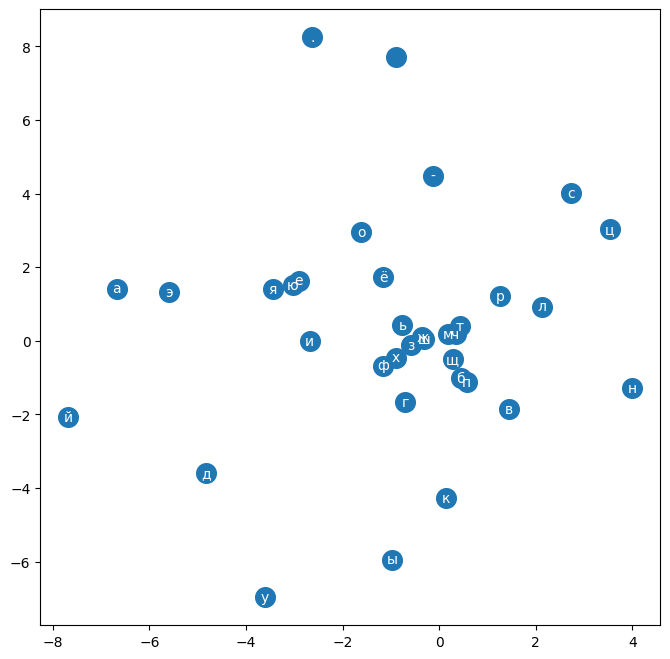

In [6]:
eval_loss(x_trn, y_trn)
eval_loss(x_dev, y_dev)
eval_loss(x_tst, y_tst)
if model.EMB_SZ == 2:
    model.scatter_plot_C().show()

In [7]:
for _ in range(30):
    ctx = [0] * d.CTX_SZ
    word = ''
    while True:        
        logits = model(torch.tensor(ctx))
        probs = F.softmax(logits, dim=1)        
        idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        if idx == 0:
            break
        ctx = ctx[1:] + [idx]
        word += d.itoch[idx]
    print(word)


плазариценгель
сызвычегорязарков
долиск
велидов
щий
лунаново
ссхалономимай
иньлясуйн
крыи рок
сирск
тащас
нов
иганта
ижа
дндальск
кизлинск
гукков
кирово
сарабеликино
ново
бар
шихи
курск
со
кормер
гудерск
вытевкарча
рово
кирогорск
брадноозёрым
